In [1]:
# Import Libraries

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm 
from statsmodels.iolib.summary2 import summary_col 

In [2]:
# Create a Spark Session
spark = SparkSession.builder.appName("EDA").getOrCreate()

In [3]:
# Load the Data
pandasdf = pd.read_excel('INMET_SE_SP_A771_2022.xlsx')
df = spark.createDataFrame(pandasdf)

In [4]:
# Basic Data Exploration
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Columns overview


,Column Name,Data type
0,Data,timestamp
1,Hora UTC,string
2,PRECIPITAÇÃO TOTAL HORÁRIO (mm),double
3,PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO HORARI...,double
4,PRESSÃO ATMOSFERICA MAX NA HORA ANT (AUT) (mB),double
5,PRESSÃO ATMOSFERICA MIN NA HORA ANT (AUT) (mB),double
6,RADIACAO GLOBAL (Kj/m²),double
7,TEMPERATURA DO AR - BULBO SECO HORARIA (°C),double
8,TEMPERATURA DO PONTO DE ORVALHO (°C),double
9,TEMPERATURA MÁXIMA NA HORA ANT (AUT) (°C),double


In [5]:
# Finding the missing values

# Get the column names
column_names = df.columns

# Get the numeric_columns
numeric_columns = column_names[2:]

missing_values = {} 
for index, column in enumerate(df.columns):
    if column in numeric_columns:  # check zeroes, None, NaN
        missing_count = df.where(col(column).isin([0,None,np.nan])).count()
        missing_values.update({column:missing_count})

missing_df = pd.DataFrame.from_dict([missing_values])
missing_df

,PRECIPITAÇÃO TOTAL HORÁRIO (mm),PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO HORARIA (mB),PRESSÃO ATMOSFERICA MAX NA HORA ANT (AUT) (mB),PRESSÃO ATMOSFERICA MIN NA HORA ANT (AUT) (mB),RADIACAO GLOBAL (Kj/m²),TEMPERATURA DO AR - BULBO SECO HORARIA (°C),TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT (AUT) (°C),TEMPERATURA ORVALHO MAX NA HORA ANT (AUT) (°C),TEMPERATURA ORVALHO MIN NA HORA ANT (AUT) (°C),UMIDADE REL MAX NA HORA ANT (AUT) (%),UMIDADE REL MIN NA HORA ANT (AUT) (%),UMIDADE RELATIVA DO AR HORARIA (%),VENTO DIREÇÃO HORARIA (gr) (° (gr)),VENTO RAJADA MAXIMA (m/s),VENTO VELOCIDADE HORARIA (m/s)
0,7855,3,3,3,4026,3,6,4,3,3,4,3,3,6,4,3,3


In [6]:
# Drop the 'Hora UTC' and 'RADIACAO GLOBAL (Kj/m²) columns
df = df.drop("Hora UTC")
df = df.drop("RADIACAO GLOBAL (Kj/m²)")

In [7]:
# Remove rows with missing values
df = df.dropna()

In [8]:
describe_result = df.describe()

# Convert the result to a Pandas DataFrame with custom column names
pandas_df_describe = describe_result.toPandas().rename(columns={'summary': 'Column Name', 'col1': 'Data type'})

# Display the Pandas DataFrame
pandas_df_describe

,Column Name,PRECIPITAÇÃO TOTAL HORÁRIO (mm),PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO HORARIA (mB),PRESSÃO ATMOSFERICA MAX NA HORA ANT (AUT) (mB),PRESSÃO ATMOSFERICA MIN NA HORA ANT (AUT) (mB),TEMPERATURA DO AR - BULBO SECO HORARIA (°C),TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT (AUT) (°C),TEMPERATURA ORVALHO MAX NA HORA ANT (AUT) (°C),TEMPERATURA ORVALHO MIN NA HORA ANT (AUT) (°C),UMIDADE REL MAX NA HORA ANT (AUT) (%),UMIDADE REL MIN NA HORA ANT (AUT) (%),UMIDADE RELATIVA DO AR HORARIA (%),VENTO DIREÇÃO HORARIA (gr) (° (gr)),VENTO RAJADA MAXIMA (m/s),VENTO VELOCIDADE HORARIA (m/s)
0,count,8273,8273,8273,8273,8273,8273,8273,8273,8273,8273,8273,8273,8273,8273,8273,8273
1,mean,0.15505862444095253,928.2106128369397,928.4526411217214,927.9661670494379,18.897534147225922,15.62036746041339,19.44408316209356,18.389628913332526,16.23638341593134,15.047310528224342,87.50670857004714,81.34703251541158,84.50271969055966,176.9954067448326,5.249836818566423,2.009512873201982
2,stddev,1.1367972033729712,3.618416923065231,3.5989716991163605,3.6329059082427344,4.504745371576752,3.9380557555493443,4.724970102025707,4.287542542558726,3.850275816437779,4.048335299443241,17.749962124603258,21.363797214848482,19.72914450115506,94.1499854299634,2.5709803248408374,1.1362595440993841
3,min,0.0,916.7,917.0,916.7,6.8,-3.0,7.3,6.5,-1.1,-5.3,18.0,15.0,17.0,1.0,0.5,0.1
4,max,40.2,940.2,940.3,940.1,33.6,24.4,34.7,32.8,25.2,23.7,100.0,100.0,100.0,360.0,19.8,8.0


In [9]:
# Avarage values for each month
from pyspark.sql.functions import month, year, avg

# Convert the 'Data' column to a date type if it's not already
df = df.withColumn("Data", df["Data"].cast("date"))

# Extract the month and year from the 'Data' column
df = df.withColumn("Month", month(df["Data"]))
df = df.withColumn("Year", year(df["Data"]))

# Get the numeric_columns
numeric_columns = [column for column in df.columns if column != "Data" and column != "Month" and column != "Year"]

# Create a list to store the aggregation expressions
agg_exprs = [avg(column).alias(f"Avg_{column}") for column in numeric_columns]

# Group by year and month, and calculate the average of numeric columns
grouped_df = df.groupBy("Year", "Month").agg(*agg_exprs)

# Show the resulting DataFrame
grouped_df_pd = grouped_df.toPandas()

grouped_df_pd

,Year,Month,Avg_PRECIPITAÇÃO TOTAL HORÁRIO (mm),Avg_PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO HORARIA (mB),Avg_PRESSÃO ATMOSFERICA MAX NA HORA ANT (AUT) (mB),Avg_PRESSÃO ATMOSFERICA MIN NA HORA ANT (AUT) (mB),Avg_TEMPERATURA DO AR - BULBO SECO HORARIA (°C),Avg_TEMPERATURA DO PONTO DE ORVALHO (°C),Avg_TEMPERATURA MÁXIMA NA HORA ANT (AUT) (°C),Avg_TEMPERATURA MÍNIMA NA HORA ANT (AUT) (°C),Avg_TEMPERATURA ORVALHO MAX NA HORA ANT (AUT) (°C),Avg_TEMPERATURA ORVALHO MIN NA HORA ANT (AUT) (°C),Avg_UMIDADE REL MAX NA HORA ANT (AUT) (%),Avg_UMIDADE REL MIN NA HORA ANT (AUT) (%),Avg_UMIDADE RELATIVA DO AR HORARIA (%),Avg_VENTO DIREÇÃO HORARIA (gr) (° (gr)),Avg_VENTO RAJADA MAXIMA (m/s),Avg_VENTO VELOCIDADE HORARIA (m/s)
0,2022,1,0.325606,925.208895,925.442183,924.966307,22.053639,19.592453,22.636792,21.521159,20.237736,18.957278,91.171159,84.641509,88.072776,195.691375,4.821294,1.683962
1,2022,2,0.132143,926.042262,926.258929,925.818155,21.943155,18.814435,22.527232,21.387649,19.541369,18.181399,88.254464,81.049107,84.665179,161.852679,5.095536,1.959077
2,2022,3,0.346237,926.727419,926.972581,926.476210,22.865591,19.327285,23.479973,22.306317,20.010215,18.696774,86.524194,79.469086,83.115591,184.591398,5.075134,1.821774
3,2022,4,0.071944,928.216528,928.444167,927.990556,20.007222,17.158750,20.517361,19.523611,17.742917,16.616806,89.131944,83.212500,86.216667,163.593056,5.198472,1.992222
4,2022,5,0.053567,929.161238,929.391252,928.931090,17.028802,13.230552,17.554105,16.540915,13.824226,12.674966,84.714670,78.558546,81.716016,195.592194,5.207268,1.930821
5,2022,6,0.047500,929.867083,930.092917,929.636111,16.208750,13.144583,16.703889,15.747222,13.676250,12.657639,88.216667,83.044444,85.661111,189.151389,4.457778,1.753333
6,2022,7,0.011321,930.816038,931.026415,930.602695,17.772911,12.161321,18.378167,17.209838,12.799865,11.568329,78.353100,71.971698,75.173854,193.319407,4.652830,1.811860
7,2022,8,0.059409,931.104032,931.344086,930.859274,16.084140,12.084274,16.590860,15.604570,12.690323,11.526478,84.670699,78.475806,81.595430,165.688172,5.819086,2.280108
8,2022,9,0.210306,929.636630,929.941783,929.338719,15.645961,13.034401,16.126323,15.201950,13.543454,12.552368,90.172702,85.367688,87.855153,166.325905,5.904596,2.364206
9,2022,10,0.145161,927.357392,927.634543,927.087231,19.407796,16.693011,19.938172,18.910887,17.270968,16.147312,89.946237,84.216398,87.166667,169.370968,5.394489,2.104167


In [10]:
# Filter the rows where the month is 8
august_df = df.filter(month("Data") == 8)

# Show the resulting DataFrame
august_df_pd = august_df.toPandas()

august_df_pd.head()

,Data,PRECIPITAÇÃO TOTAL HORÁRIO (mm),PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO HORARIA (mB),PRESSÃO ATMOSFERICA MAX NA HORA ANT (AUT) (mB),PRESSÃO ATMOSFERICA MIN NA HORA ANT (AUT) (mB),TEMPERATURA DO AR - BULBO SECO HORARIA (°C),TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT (AUT) (°C),TEMPERATURA ORVALHO MAX NA HORA ANT (AUT) (°C),TEMPERATURA ORVALHO MIN NA HORA ANT (AUT) (°C),UMIDADE REL MAX NA HORA ANT (AUT) (%),UMIDADE REL MIN NA HORA ANT (AUT) (%),UMIDADE RELATIVA DO AR HORARIA (%),VENTO DIREÇÃO HORARIA (gr) (° (gr)),VENTO RAJADA MAXIMA (m/s),VENTO VELOCIDADE HORARIA (m/s),Month,Year
0,2022-08-01,0.0,930.6,930.6,930.3,12.6,12.6,12.7,12.3,12.7,12.2,100.0,100.0,100.0,131.0,3.9,1.7,8,2022
1,2022-08-01,0.0,930.8,930.8,930.6,12.5,12.5,12.7,12.5,12.7,12.5,100.0,100.0,100.0,91.0,3.4,1.1,8,2022
2,2022-08-01,0.0,931.0,931.0,930.7,11.9,11.9,12.5,11.9,12.5,11.9,100.0,100.0,100.0,69.0,2.1,0.7,8,2022
3,2022-08-01,0.0,931.0,931.1,931.0,12.0,12.0,12.1,11.9,12.1,11.9,100.0,100.0,100.0,124.0,2.0,0.5,8,2022
4,2022-08-01,0.0,930.8,931.0,930.8,11.7,11.7,12.0,11.6,12.0,11.6,100.0,100.0,100.0,152.0,1.7,0.8,8,2022


In [11]:
# Get the number of rows
num_rows = august_df.count()

# Get the list of column names
column_names = august_df.columns

# Display the dimensions
print(f"Number of Rows: {num_rows}")
print(f"Number of Columns: {len(column_names)}")

Number of Rows: 744
Number of Columns: 19


In [12]:
column_names

['Data',
 'PRECIPITAÇÃO TOTAL HORÁRIO (mm)',
 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO HORARIA (mB)',
 'PRESSÃO ATMOSFERICA MAX NA HORA ANT  (AUT) (mB)',
 'PRESSÃO ATMOSFERICA MIN NA HORA ANT (AUT) (mB)',
 'TEMPERATURA DO AR - BULBO SECO HORARIA (°C)',
 'TEMPERATURA DO PONTO DE ORVALHO (°C)',
 'TEMPERATURA MÁXIMA NA HORA ANT (AUT) (°C)',
 'TEMPERATURA MÍNIMA NA HORA ANT (AUT) (°C)',
 'TEMPERATURA ORVALHO MAX NA HORA ANT (AUT) (°C)',
 'TEMPERATURA ORVALHO MIN NA HORA ANT (AUT) (°C)',
 'UMIDADE REL MAX NA HORA ANT (AUT) (%)',
 'UMIDADE REL MIN NA HORA ANT (AUT) (%)',
 'UMIDADE RELATIVA DO AR HORARIA (%)',
 'VENTO DIREÇÃO HORARIA (gr) (° (gr))',
 'VENTO RAJADA MAXIMA (m/s)',
 'VENTO VELOCIDADE HORARIA (m/s)',
 'Month',
 'Year']

In [13]:
# List the columns you want to calculate the averages for
columns_to_average = [
    ('PRESSÃO ATMOSFERICA MAX NA HORA ANT  (AUT) (mB)', 'PRESSÃO ATMOSFERICA MIN NA HORA ANT (AUT) (mB)'),
    ('TEMPERATURA MÁXIMA NA HORA ANT (AUT) (°C)', 'TEMPERATURA MÍNIMA NA HORA ANT (AUT) (°C)'),
    ('TEMPERATURA ORVALHO MAX NA HORA ANT (AUT) (°C)', 'TEMPERATURA ORVALHO MIN NA HORA ANT (AUT) (°C)'),
    ('UMIDADE REL MAX NA HORA ANT (AUT) (%)', 'UMIDADE REL MIN NA HORA ANT (AUT) (%)'),
    ('VENTO RAJADA MAXIMA (m/s)', 'VENTO VELOCIDADE HORARIA (m/s)')
]

# Create a new DataFrame to store the averages
aug_avg_df_pd = pd.DataFrame()

# Calculate and store the averages for each column pair
for col1, col2 in columns_to_average:
    average_col_name = f'AVERAGE_{col1}_{col2}'  # Create a new column name
    aug_avg_df_pd[average_col_name] = (august_df_pd[col1] + august_df_pd[col2]) / 2

# Select the columns you want to keep from the original DataFrame
columns_to_keep = ['PRECIPITAÇÃO TOTAL HORÁRIO (mm)']

# Select those columns from the original DataFrame
selected_columns = august_df_pd[columns_to_keep]

# Concatenate the selected columns with the DataFrame containing averages
aug_df_pd = pd.concat([selected_columns, aug_avg_df_pd], axis=1)

# Show de df
aug_df_pd.head()

,PRECIPITAÇÃO TOTAL HORÁRIO (mm),AVERAGE_PRESSÃO ATMOSFERICA MAX NA HORA ANT (AUT) (mB)_PRESSÃO ATMOSFERICA MIN NA HORA ANT (AUT) (mB),AVERAGE_TEMPERATURA MÁXIMA NA HORA ANT (AUT) (°C)_TEMPERATURA MÍNIMA NA HORA ANT (AUT) (°C),AVERAGE_TEMPERATURA ORVALHO MAX NA HORA ANT (AUT) (°C)_TEMPERATURA ORVALHO MIN NA HORA ANT (AUT) (°C),AVERAGE_UMIDADE REL MAX NA HORA ANT (AUT) (%)_UMIDADE REL MIN NA HORA ANT (AUT) (%),AVERAGE_VENTO RAJADA MAXIMA (m/s)_VENTO VELOCIDADE HORARIA (m/s)
0,0.0,930.45,12.5,12.45,100.0,2.80
1,0.0,930.70,12.6,12.60,100.0,2.25
2,0.0,930.85,12.2,12.20,100.0,1.40
3,0.0,931.05,12.0,12.00,100.0,1.25
4,0.0,930.90,11.8,11.80,100.0,1.25


In [14]:
# Your original column names
original_columns = ['PRECIPITAÇÃO TOTAL HORÁRIO (mm)',
                    'AVERAGE_PRESSÃO ATMOSFERICA MAX NA HORA ANT  (AUT) (mB)_PRESSÃO ATMOSFERICA MIN NA HORA ANT (AUT) (mB)',
                    'AVERAGE_TEMPERATURA MÁXIMA NA HORA ANT (AUT) (°C)_TEMPERATURA MÍNIMA NA HORA ANT (AUT) (°C)',
                    'AVERAGE_TEMPERATURA ORVALHO MAX NA HORA ANT (AUT) (°C)_TEMPERATURA ORVALHO MIN NA HORA ANT (AUT) (°C)',
                    'AVERAGE_UMIDADE REL MAX NA HORA ANT (AUT) (%)_UMIDADE REL MIN NA HORA ANT (AUT) (%)',
                    'AVERAGE_VENTO RAJADA MAXIMA (m/s)_VENTO VELOCIDADE HORARIA (m/s)']

# Simplify the column names
simplified_columns = [
    'Precipitation',
    'Avarage_Atmospheric_Pressure',
    'Avarage_Temperature',
    'Avarage_Dew_Temperature',
    'Avarage_Relative_Humidity',
    'Avarage_Wind_Speed'
]

# Rename the columns in the DataFrame
aug_df_pd.columns = simplified_columns

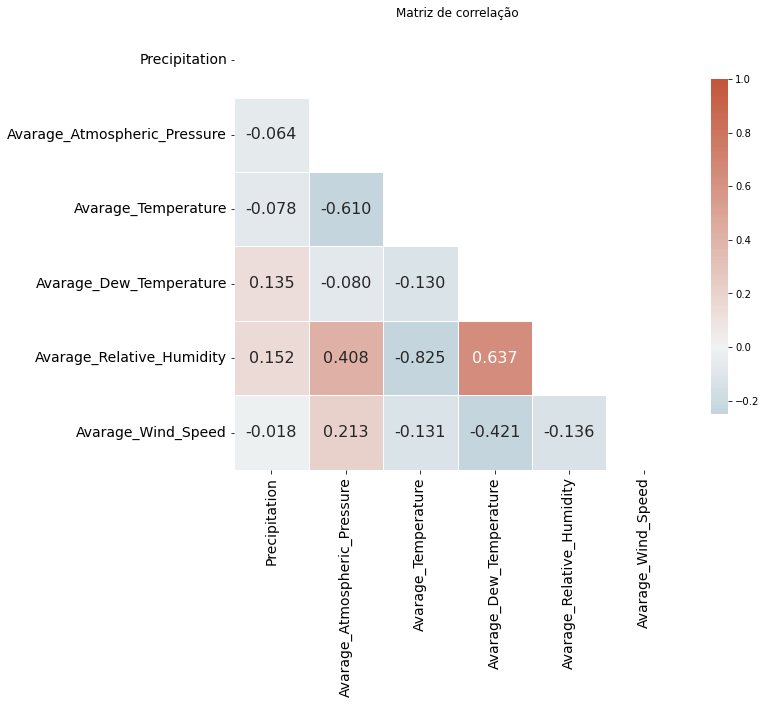

In [15]:
# Another way to plot the same information

corr = aug_df_pd.corr()

f, ax = plt.subplots(figsize=(11, 9))

mask = np.triu(np.ones_like(corr, dtype=bool))

cmap = sns.diverging_palette(230, 20, n=256, as_cmap=True)

sns.heatmap(aug_df_pd.corr(), 
            mask=mask, 
            cmap=cmap, 
            vmax=1, 
            vmin = -.25,
            center=0,
            square=True, 
            linewidths=.5,
            annot = True,
            fmt='.3f', 
            annot_kws={'size': 16},
            cbar_kws={"shrink": .75})

plt.title('Matriz de correlação')
plt.tight_layout()
ax.tick_params(axis = 'x', labelsize = 14)
ax.tick_params(axis = 'y', labelsize = 14)
ax.set_ylim(len(corr))

plt.show()

In [16]:
# Specify the file path where you want to save the CSV file
csv_file_path = "weather_august.csv"

# Use the to_csv method to export the DataFrame to a CSV file
aug_df_pd.to_csv(csv_file_path, index=False)  # Set index=False to exclude the index column in the CSV file